In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary
import torch_lr_finder

from utils.trainer import Trainer
from utils.tester import Tester
from utils.dataloader import Cifar10DataLoader,Cifar10Dataset
from utils.transformation import train_transforms, test_transforms
from utils.tools import visualize_data,show_misclassified_images,plot_curves,plot_confusion_matrix,lr_curve,show_grad_cam_images
from models.resnet import ResNet18

c:\Users\muthu\miniconda3\envs\venv\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(1)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

torch.cuda.amp.autocast(enabled=True,dtype=torch.float16)
torch.set_float32_matmul_precision('medium')

In [3]:
# CIFAR10 Data
train_data = Cifar10Dataset(root='../../data',train=True,download=False,transform=train_transforms)
test_data = Cifar10Dataset(root='../../data',train=False,download=False,transform=test_transforms)

# CIFAR10 DataLoader
loader = Cifar10DataLoader(batch_size=512,is_cuda_available=True)
train_loader = loader.get_loader(train_data,train=True)
test_loader  = loader.get_loader(test_data,train=False)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Is CUDA available? ", use_cuda)

Is CUDA available?  True


In [5]:
model = ResNet18().to(device)
summary(model,(3,32,32),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

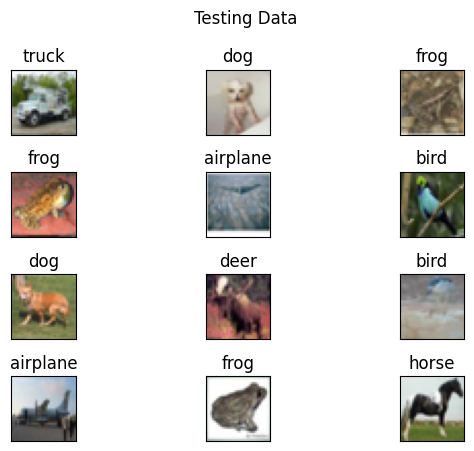

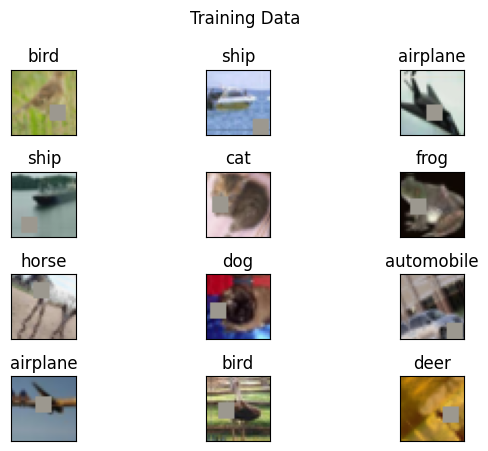

In [6]:
visualize_data(test_loader,12,"Testing Data",classes=test_data.classes);
visualize_data(train_loader,12,"Training Data",classes=train_data.classes);

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer =  optim.Adam(model.parameters(),lr=0.003,weight_decay=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',patience=3)
EPOCH=20

 70%|███████   | 140/200 [00:55<00:23,  2.53it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 7.66E-03


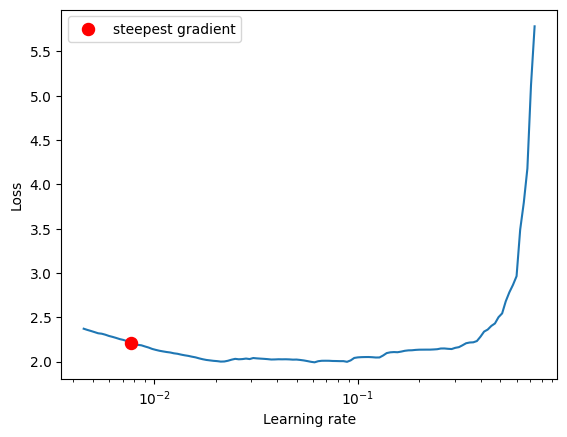

In [8]:
lr_finder = torch_lr_finder.LRFinder(model,optimizer,criterion,device=device)
lr_finder.range_test(train_loader,end_lr=10,num_iter=200,step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [9]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,max_lr=7.66e-03,
                                           pct_start=3/EPOCH,  #5/EPOCH
                                          anneal_strategy='linear',
                                        #   cycle_momentum=True,
                                        #   base_momentum=0.85,
                                        #   max_momentum=0.98,
                                          steps_per_epoch=len(train_loader),
                                          epochs= EPOCH,
                                          three_phase=False,
                                          div_factor=100,
                                          final_div_factor=100)

In [10]:
trainer = Trainer(model, train_loader, optimizer, criterion,scheduler, device)
tester = Tester(model, test_loader, criterion, device)

for epoch in range(0, EPOCH):
    trainer.train(epoch=epoch)
    test_acc,test_loss = tester.test()
    print('-'*150)

EPOCH=0| LR=0.002613027303754266| LOSS=1.43| BATCH=97| ACCURACY=40.876: 100%|██████████| 98/98 [00:39<00:00,  2.45it/s]  
LOSS=31.77| BATCH=19| ACCURACY=41.510: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=1| LR=0.005149454607508532| LOSS=1.42| BATCH=97| ACCURACY=50.880: 100%|██████████| 98/98 [00:39<00:00,  2.45it/s] 
LOSS=36.58| BATCH=19| ACCURACY=38.170: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=2| LR=0.00765540262064826| LOSS=1.27| BATCH=97| ACCURACY=53.964: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s]  
LOSS=32.95| BATCH=19| ACCURACY=37.970: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=3| LR=0.007204859444177671| LOSS=1.05| BATCH=97| ACCURACY=57.136: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s] 
LOSS=25.74| BATCH=19| ACCURACY=52.000: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=4| LR=0.006754316267707083| LOSS=1.12| BATCH=97| ACCURACY=60.682: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s] 
LOSS=25.67| BATCH=19| ACCURACY=57.740: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=5| LR=0.006303773091236494| LOSS=0.94| BATCH=97| ACCURACY=62.646: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s] 
LOSS=24.35| BATCH=19| ACCURACY=59.150: 100%|██████████| 20/20 [00:08<00:00,  2.22it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=6| LR=0.005853229914765907| LOSS=0.92| BATCH=97| ACCURACY=65.164: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s] 
LOSS=25.35| BATCH=19| ACCURACY=57.340: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=7| LR=0.0054026867382953175| LOSS=1.01| BATCH=97| ACCURACY=66.442: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]
LOSS=23.91| BATCH=19| ACCURACY=58.100: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=8| LR=0.00495214356182473| LOSS=0.81| BATCH=97| ACCURACY=68.140: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]  
LOSS=15.53| BATCH=19| ACCURACY=73.710: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=9| LR=0.004501600385354142| LOSS=0.89| BATCH=97| ACCURACY=69.660: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s] 
LOSS=17.00| BATCH=19| ACCURACY=71.180: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=10| LR=0.004051057208883553| LOSS=0.82| BATCH=97| ACCURACY=70.674: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s] 
LOSS=15.07| BATCH=19| ACCURACY=74.110: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=11| LR=0.0036005140324129655| LOSS=0.83| BATCH=97| ACCURACY=72.334: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]
LOSS=15.07| BATCH=19| ACCURACY=73.650: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=12| LR=0.003149970855942377| LOSS=0.81| BATCH=97| ACCURACY=73.652: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s] 
LOSS=13.65| BATCH=19| ACCURACY=76.360: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=13| LR=0.0026994276794717886| LOSS=0.72| BATCH=97| ACCURACY=75.048: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]
LOSS=12.71| BATCH=19| ACCURACY=78.640: 100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=14| LR=0.002248884503001201| LOSS=0.70| BATCH=97| ACCURACY=76.278: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s] 
LOSS=11.48| BATCH=19| ACCURACY=80.530: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=15| LR=0.0017983413265306126| LOSS=0.65| BATCH=97| ACCURACY=77.296: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]
LOSS=10.24| BATCH=19| ACCURACY=82.280: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=16| LR=0.0013477981500600242| LOSS=0.51| BATCH=97| ACCURACY=78.916: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]
LOSS=10.02| BATCH=19| ACCURACY=83.320: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=17| LR=0.0008972549735894357| LOSS=0.63| BATCH=97| ACCURACY=80.848: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]
LOSS=8.16| BATCH=19| ACCURACY=85.740: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=18| LR=0.0004467117971188473| LOSS=0.49| BATCH=97| ACCURACY=82.376: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s] 
LOSS=7.00| BATCH=19| ACCURACY=87.790: 100%|██████████| 20/20 [00:08<00:00,  2.22it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=19| LR=-3.831379351739404e-06| LOSS=0.40| BATCH=97| ACCURACY=84.294: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]
LOSS=6.35| BATCH=19| ACCURACY=88.970: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------


In [11]:
misclassified_images, misclassified_predictions, labels = tester.get_misclassified_images()

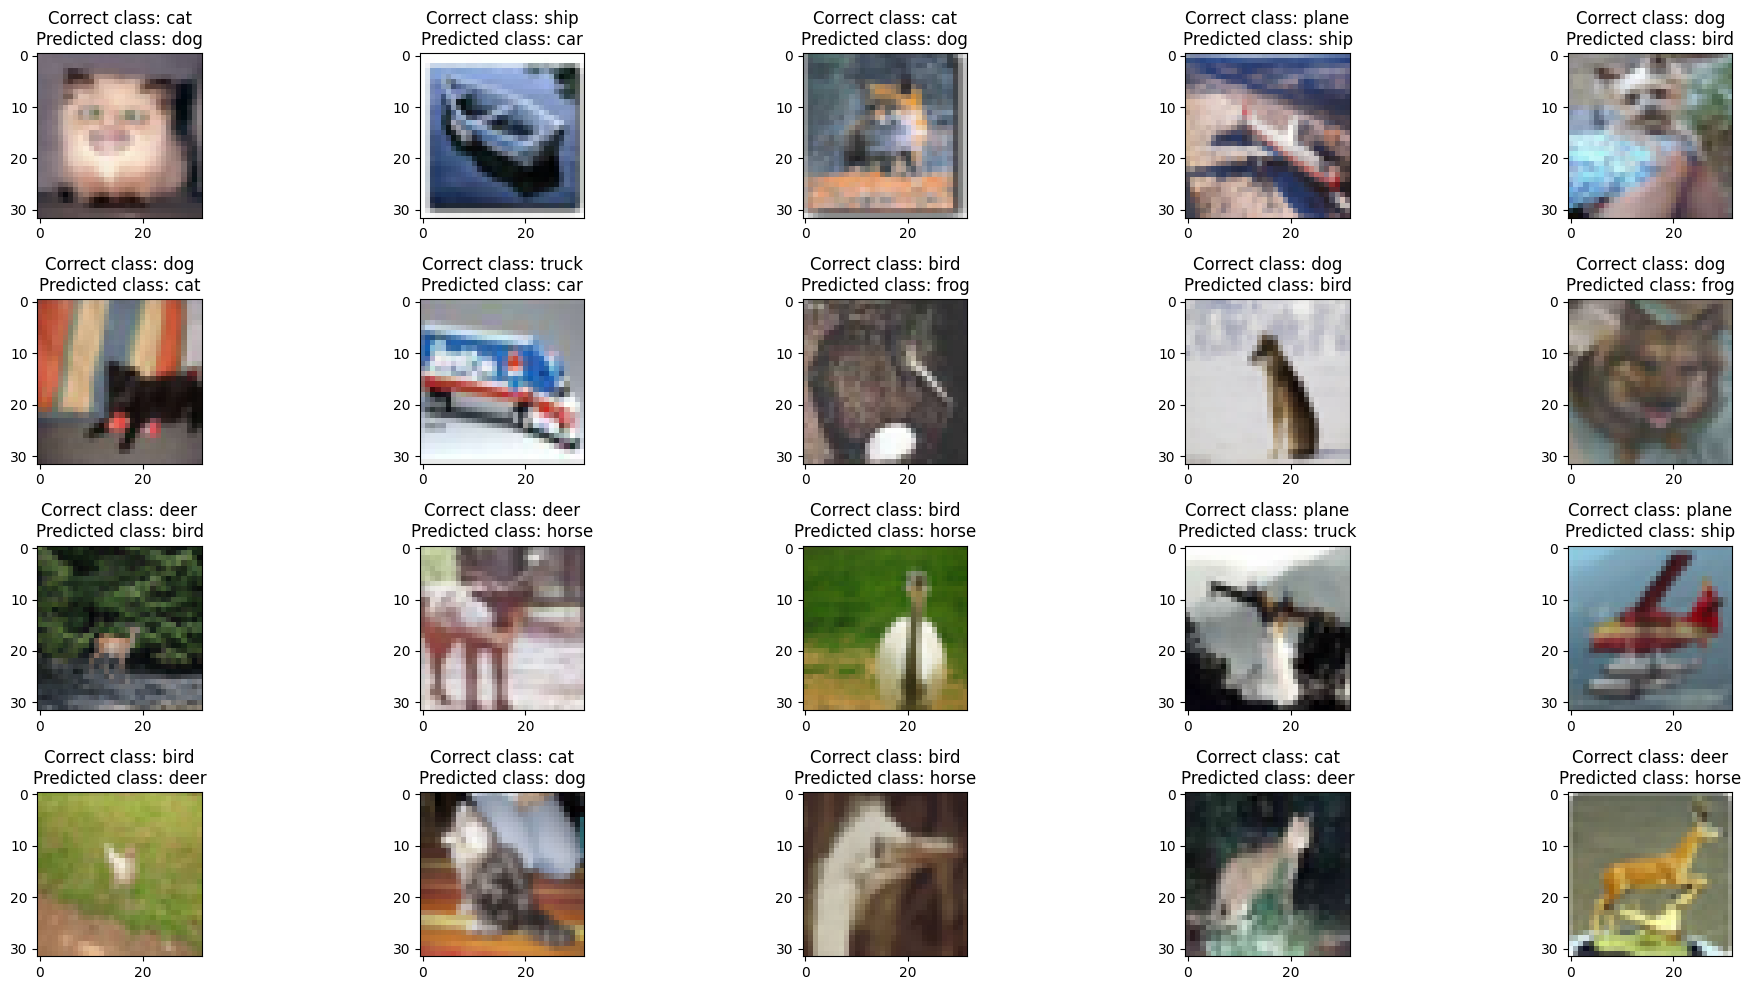

In [12]:
show_misclassified_images(
    misclassified_images[:20],
    misclassified_predictions[:20],
    labels[:20],
    [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ],
);


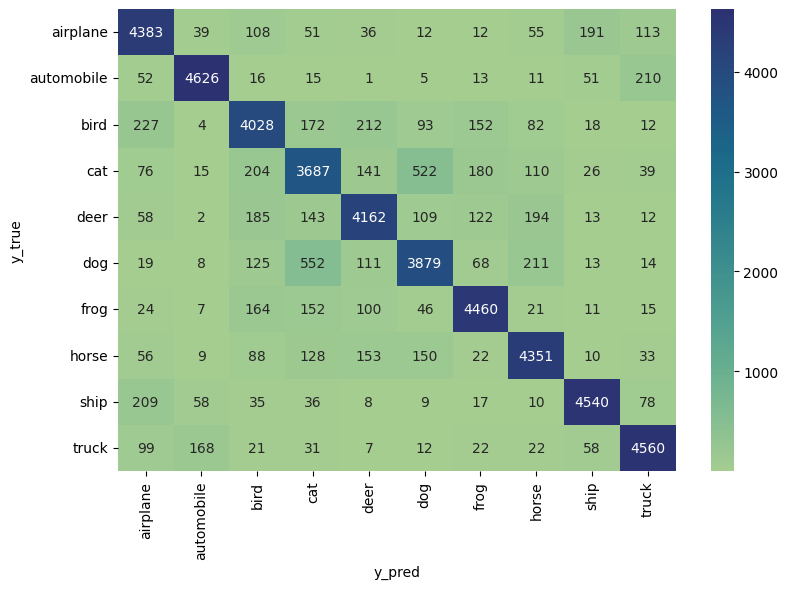

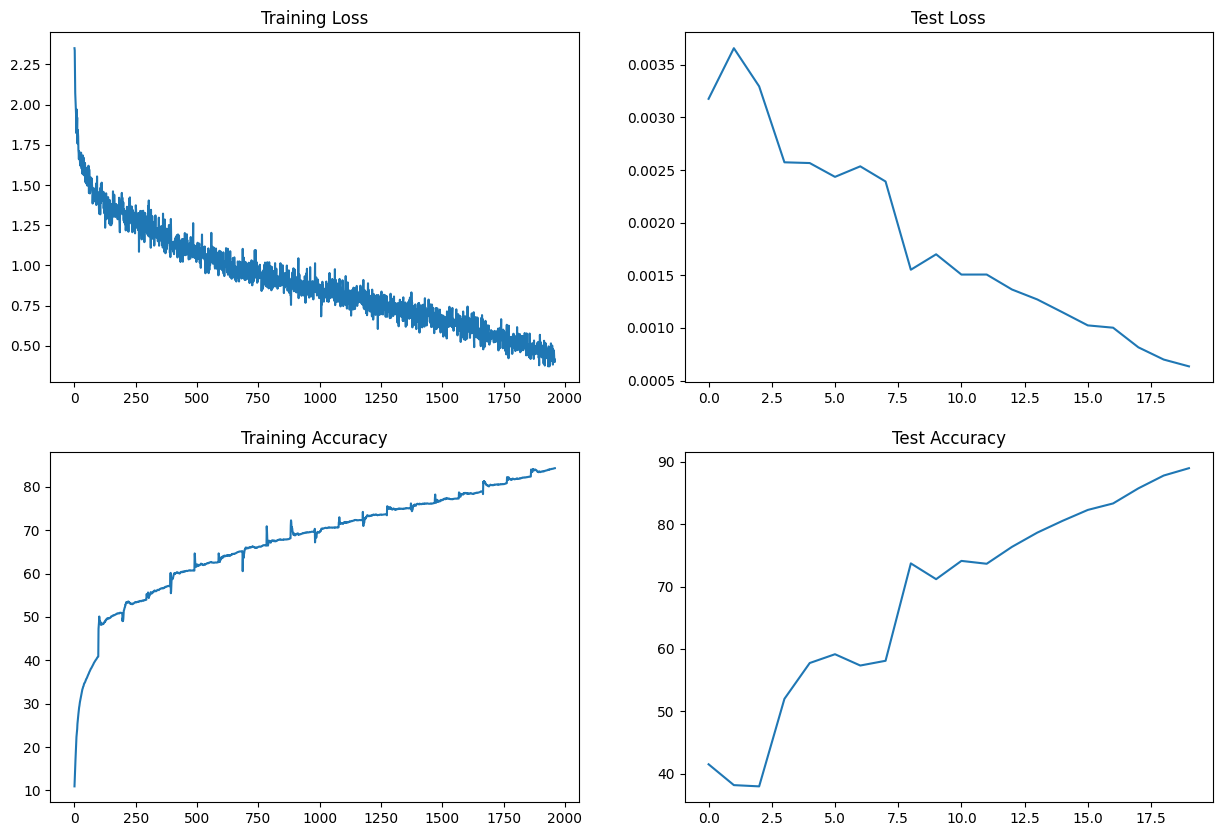

In [13]:
plot_confusion_matrix(model,train_loader,'cuda',train_loader.dataset.classes);
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies);

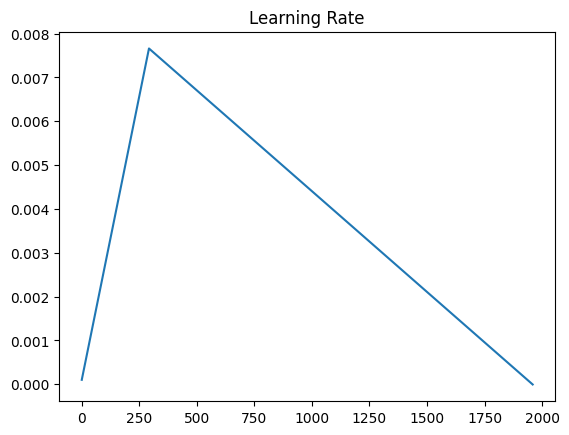

In [14]:
lr_curve(trainer.lr_history)

c:\Users\muthu\Documents\ZerotoHeroDL 🫶\Vision\Ch11\utils\tools.py:218: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


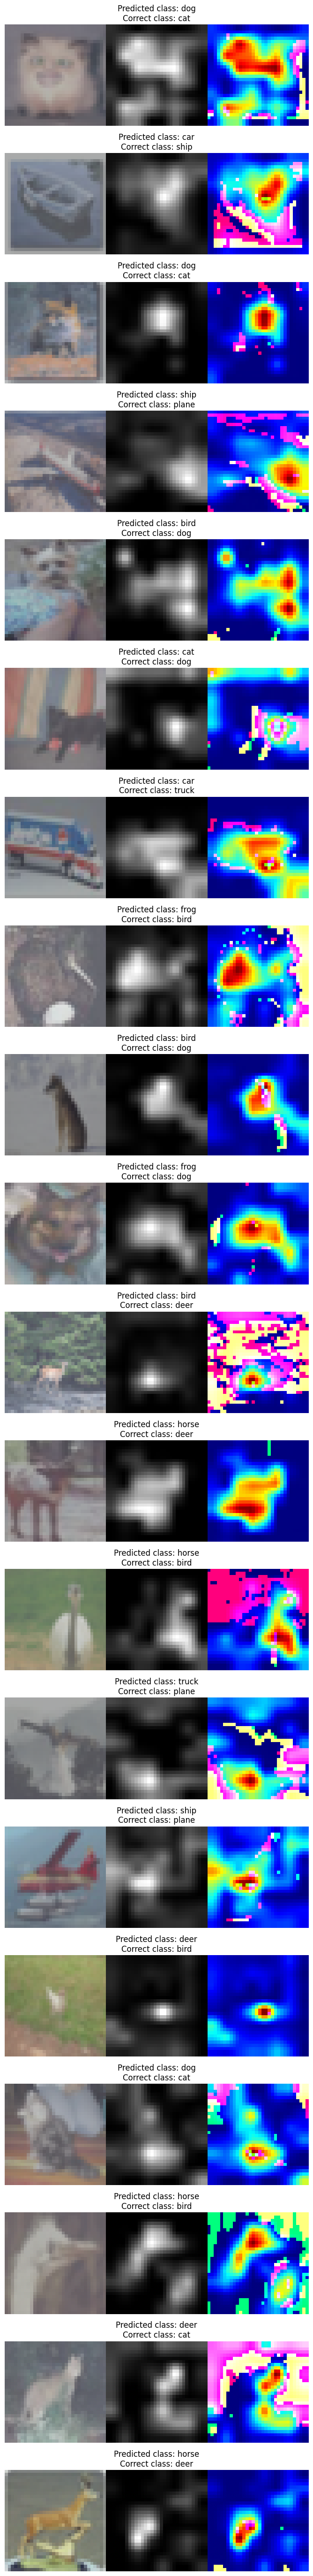

In [15]:
show_grad_cam_images(model,[model.layer3],misclassified_images,misclassified_predictions,labels,[
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ])